In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
# import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

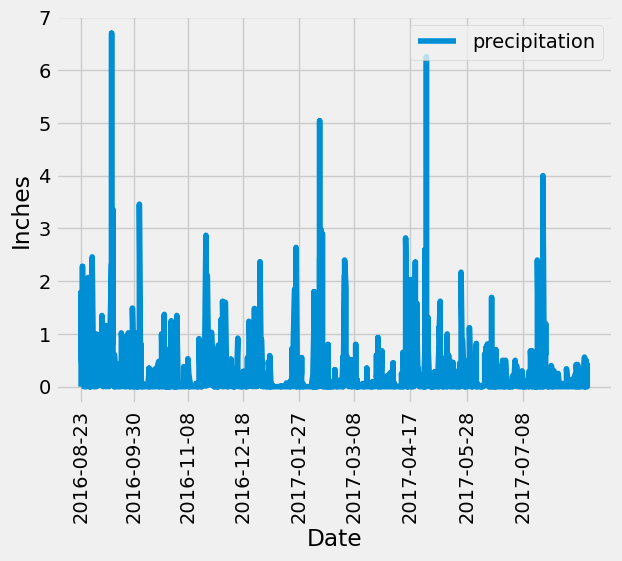

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(most_recent_date)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).filter(Measurement.prcp.isnot(None)).filter(Measurement.date>=one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names AND sort by date
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'precipitation']).sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precipitation_df['date']
y_axis = precipitation_df['precipitation']
plt.plot(x_axis, y_axis)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(["precipitation"],loc='upper right')
plt.xticks(x_axis, rotation='vertical')
plt.locator_params(axis='x', nbins=9)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Measurement.station).distinct().count()
number_of_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations_list = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
most_active_stations_list


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations_list[0][0]

most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

most_active_stats

[(54.0, 85.0, 71.66378066378067)]

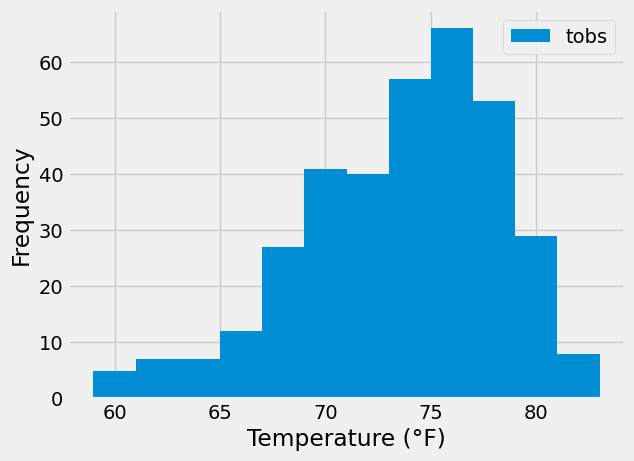

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_temp_stats = session.query(Measurement.tobs).filter(Measurement.prcp.isnot(None)).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()

#create df for histogram temp results
tobs_list = [{"tobs": result[0]} for result in hist_temp_stats]
tobs_df = pd.DataFrame(tobs_list)

#create histogram
ax = tobs_df.plot.hist(bins=12)
ax.set_xlabel("Temperature (°F)")
ax.set_ylabel("Frequency");

# Close Session

In [18]:
# Close Session
session.close()